# 1 ライブラリとデータ

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

torch.manual_seed(1)

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1))])

root = './data2'
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

train_dataloader = DataLoader(mnist_train,batch_size=100,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size=100,shuffle=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


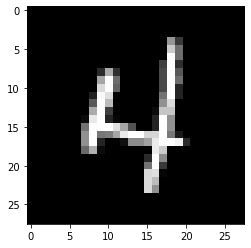

In [3]:
x, t = next(iter(train_dataloader))
image = x[0,].view(28,28).detach().numpy()
plt.imshow(image,cmap='binary_r')

# 2 モデル

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.b1 = nn.BatchNorm2d(32)
        self.c2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.b2 = nn.BatchNorm2d(64)
        self.l1 = nn.Linear(576,128)
        self.b3 = nn.BatchNorm1d(128)
        self.l2 = nn.Linear(128,10)
    def forward(self,x):
        x = torch.relu(self.b1(self.c1(x)))
        x = F.max_pool2d(torch.relu(self.b2(self.c2(x))),2)
        x = x.view(-1,576)
        x = torch.relu(self.b3(self.l1(x)))
        x = self.l2(x)
        return x

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=1e-2)

# 3 モデルの学習と評価

In [7]:
loss_train_all = []
acc_train_all = []
loss_test_all = []
acc_test_all = []

for epoch in range(1, 20+1):
    
    loss_train = 0
    acc_train = 0
    loss_test = 0
    acc_test = 0
    
    model.train()
    for (x,t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        y = model(x)
        loss = criterion(y,t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
        acc_train += sum(y.argmax(axis=1) == t)/len(t)
        
    loss_train_mean = loss_train / len(train_dataloader)
    acc_train_mean = acc_train / len(train_dataloader)
    
    model.eval()
    with torch.no_grad():
        for x, t in test_dataloader:
            x, t = x.to(device), t.to(device)
            y = model(x)
            loss = criterion(y,t)
        
            loss_test += loss.item()
            acc_test += sum(y.argmax(axis=1) == t)/len(t)
        
    loss_test_mean = loss_test / len(test_dataloader)
    acc_test_mean = acc_test / len(test_dataloader)
    
    loss_train_all.append(loss_train_mean)
    acc_train_all.append(acc_train_mean)
    loss_test_all.append(loss_test_mean)
    acc_test_all.append(acc_test_mean)
    
    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch: {epoch}")
        print(f"loss_train: {loss_train_mean:.4f}, acc_train: {acc_train_mean:.4f}")
        print(f"loss_test: {loss_test_mean:.4f}, acc_test: {acc_test_mean:.4f}")    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1
loss_train: 0.4994, acc_train: 0.9020
loss_test: 0.1746, acc_test: 0.9647
Epoch: 5
loss_train: 0.0634, acc_train: 0.9853
loss_test: 0.0546, acc_test: 0.9866
Epoch: 10
loss_train: 0.0339, acc_train: 0.9924
loss_test: 0.0390, acc_test: 0.9878
Epoch: 15
loss_train: 0.0216, acc_train: 0.9958
loss_test: 0.0342, acc_test: 0.9897
Epoch: 20
loss_train: 0.0148, acc_train: 0.9981
loss_test: 0.0314, acc_test: 0.9897


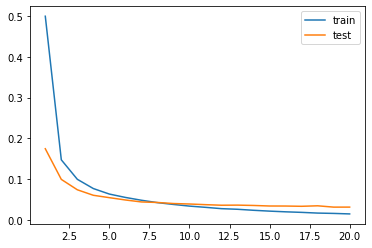

In [8]:
plt.plot(range(1,len(loss_train_all)+1), loss_train_all, label="train")
plt.plot(range(1,len(loss_test_all)+1), loss_test_all, label="test")
plt.legend()

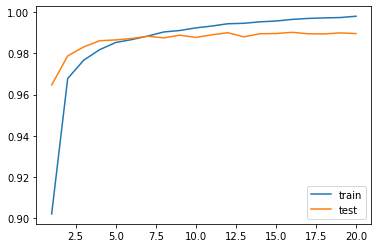

In [9]:
plt.plot(range(1,len(acc_train_all)+1), acc_train_all, label="train")
plt.plot(range(1,len(acc_test_all)+1), acc_test_all, label="test")
plt.legend()